In [110]:
%pip install --quiet seaborn pyarrow tqdm pandarallel ipywidgets bert_score joblib rouge sacrebleu rouge-score rouge-metric

Note: you may need to restart the kernel to use updated packages.


In [111]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from normalizer import normalize
from bert_score import score
from IPython.display import display
from rouge import Rouge
import sacrebleu
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import warnings
warnings.filterwarnings('ignore')

#### 📰 Summary Dataset Field Descriptions (articles_final.csv)

| Field Name          | Description                                                                      |
| ------------------- | -------------------------------------------------------------------------------- |
| **`textbn`**   | Full news article written in **Bangla**                                             |
| **`texten`**       | Full news article written in **English**                                          |
| **`textbn_predicted`**    | Full news article translated to **Bangla**  by PressWiz                          |
| **`texten_predicted`**       | Full news article translated to **English**   by PressWiz                                         |
| **`texten_gt`**    | Full news article translated to **English**   by Google Translator                                      |
| **`textbn_gt`** | Full news article translated to **Bangla**   by Google Translator    |


#### 📰 Summary Dataset Field Descriptions (summaries_final.csv)

| Field Name          | Description                                                                      |
| ------------------- | -------------------------------------------------------------------------------- |
| **`source_name`**   | Name of the newspaper or news source                                             |
| **`content`**       | Full news article written in **Bangla**                                          |
| **`content_en`**    | Full news article translated or written in **English**                           |
| **`summary`**       | Summary of the news article in **Bangla**                                        |
| **`summary_en`**    | Summary of the news article in **English**                                       |
| **`summary_en_gt`** | Bangla summary (**`summary`**) translated to **English** via Google Translate    |
| **`summary_gt`**    | English summary (**`summary_en`**) translated to **Bangla** via Google Translate |


In [112]:

input_path = '/home/server02/mahmud/mt/outputs/articles_final.csv'
articles = pd.read_csv(input_path)
articles = articles.dropna()

input_path2 = '/home/server02/mahmud/mt/outputs/summaries_final.csv'
summaries = pd.read_csv(input_path2)
summaries = summaries.dropna()

In [113]:
articles.head()

,textbn,texten,textbn_predicted,texten_predicted,texten_gt,textbn_gt
0,"ট্র্যাফিক জ্যামে আটকে যখনহচ্ছে বাসে বাদুরঝোলা,...","Stuck in a traffic jam, when the Badurjola bus...",যানজটে আটকা পড়লে বাদুরঝোলা বাস থামলে চোখ খোলা...,"When a bus is stuck in traffic jams, you will ...",When you are stuck in a traffic jam and hangin...,"যানজটে আটকে থাকা অবস্থায়, বাদুরজলা বাস থামলে,..."
1,সশস্ত্রবাহিনী আয়োজিত ইফতার মাহফিলে অংশ নিয়েছ...,Prime Minister Sheikh Hasina attended an Iftar...,সশস্ত্র বাহিনী আয়োজিত ইফতার পার্টিতে যোগ দিয়...,Prime Minister Sheikh Hasina attended an Iftar...,Prime Minister Sheikh Hasina has participated ...,প্রধানমন্ত্রী শেখ হাসিনা সশস্ত্র বাহিনী আয়োজি...
2,স্বাধীনতার স্থপতি বঙ্গবন্ধু শেখ মুজিবুর রহমানে...,The book fair on the occasion of Father of the...,জাতির পিতা বঙ্গবন্ধু শেখ মুজিবুর রহমানের জন্মব...,A book fair has begun at Shishu Academy on the...,A book fair has started at Shishu Academy on t...,জাতির পিতা বঙ্গবন্ধু শেখ মুজিবুর রহমানের জন্মব...
3,বিএনপির নতুন মহাসচিব মির্জা ফখরুল ইসলাম আলমগীর...,BNP's new secretary general Mirza Fakhrul Isla...,বিএনপির নতুন মহাসচিব মির্জা ফখরুল ইসলাম আলমগীর...,BNP's new secretary general Mirza Fakhrul Isla...,BNP's new Secretary General Mirza Fakhrul Isla...,বিএনপির নতুন মহাসচিব মির্জা ফখরুল ইসলাম আলমগীর...
4,কোনো কারণ ছাড়াই নিউজ প্রোটাল পরিবর্তন ডটকম বন...,The Surokkha Forum leaders have expressed deep...,কোনো কারণ ছাড়াই নিউজ পোর্টাল পরিবর্তন ডটকম বন...,"The leaders of the Sushil Forum, including Pre...","Sushil Forum President Md. Zahid, Senior Vice ...",সুরক্ষা ফোরামের নেতারা কোনও কারণ ছাড়াই নিউজ প...


In [114]:
summaries.head()

,id,source_name,content,content_en,summary,summary_en,summary_en_gt,summary_gt
0,26608,samakal,ক্লাব বিশ্বকাপে মেক্সিকান ক্লাব পাচুকার বিপক্ষ...,Real Madrid won 3-1 against Mexican club Pachu...,ক্লাব বিশ্বকাপে মেক্সিকোর ক্লাব পাচুকাকে ৩-১ গ...,Real Madrid defeated Mexican club Pachuca 3-1 ...,Real Madrid beat Mexican club Pachuca 3-1 in t...,ক্লাব বিশ্বকাপে জার্মান ডিফেন্ডার আন্তোইন রুডি...
1,26604,samakal,টানা ৪০ দিন বন্ধ থাকার পর অবশেষে চালু হলো ঢাকা...,"After being closed for 40 consecutive days, Dh...",৪০ দিন বন্ধ থাকার পর আজ সোমবার ঢাকা দক্ষিণ সিট...,"Dhaka South City Corporation's headquarters, c...","After being closed for 40 days, the Dhaka Sout...",৪০ দিন ধরে বন্ধ ঢাকা দক্ষিণ সিটি কর্পোরেশনের স...
2,26599,samakal,জাতীয় রাজস্ব বোর্ডের-এনবিআর পাঁচ উপ-কর কমিশনা...,Five deputy tax commissioners of the National ...,জাতীয় রাজস্ব বোর্ডের (এনবিআর) পাঁচ উপকর কমিশন...,Five deputy tax commissioners of the National ...,Five Excise Commissioners of the National Boar...,জাতীয় রাজস্ব বোর্ডের (এনবিআর) পাঁচজন উপ-কর কম...
3,26598,samakal,সাবেক প্রধান নির্বাচন কমিশনার হাবিবুল আউয়ালকে...,Former Chief Election Commissioner Habibul Awa...,সাবেক প্রধান নির্বাচন কমিশনার (সিইসি) মো. নূরু...,Former Chief Election Commissioner Habibul Awa...,Former Chief Election Commissioner (CEC) Md. N...,স্বরাষ্ট্র উপদেষ্টা লেফটেন্যান্ট জেনারেল জাহাঙ...
4,26596,samakal,সিরিয়ার উত্তরপূর্বাঞ্চলীয় হাসাকাহ প্রদেশে অব...,A US military base in the northeastern Syrian ...,সিরিয়ার হাসাকা প্রদেশে মার্কিন সামরিক ঘাঁটিতে...,A US military base in Hasakah province Syria w...,A mortar attack has hit a US military base in ...,"ইরানের সংবাদমাধ্যম মেহের নিউজ জানিয়েছে, সিরিয..."


# Basic Stats

╔═══════════════════════════════════════════════════════════════╗
║                  📰 ARTICLES Translation Overview              ║
╚═══════════════════════════════════════════════════════════════╝

📦 Total Articles: 4,916
📊 Total Fields: 6
🔤 Text Fields Analyzed: 6

╔═══════════════════════════════════════════════════════════════╗
║              📏 CHARACTER LENGTH STATISTICS                    ║
╚═══════════════════════════════════════════════════════════════╝


,Mean,Median,Std Dev,Min,Max,Q1 (25%),Q3 (75%)
Original Bangla,"1,371","1,280",571,373,"3,413",909,"1,780"
Original English,"1,542","1,424",663,189,"3,396","1,017","2,013"
PressWiz → Bangla,"1,313","1,221",551,202,"5,614",870,"1,702"
PressWiz → English,"1,531","1,432",673,65,"3,464","1,016","1,992"
Google → English,"1,570","1,457",665,365,"3,414","1,040","2,053"
Google → Bangla,"1,370","1,277",585,3,"3,354",897,"1,801"



╔═══════════════════════════════════════════════════════════════╗
║                  📊 WORD COUNT STATISTICS                      ║
╚═══════════════════════════════════════════════════════════════╝


,Mean Words,Median Words,Min Words,Max Words,Total Words
Original Bangla,203,189,28,562,"995,818"
Original English,253,233,4,602,"1,243,347"
PressWiz → Bangla,195,180,29,684,"956,221"
PressWiz → English,252,235,11,629,"1,237,975"
Google → English,260,241,36,620,"1,278,728"
Google → Bangla,204,189,2,522,"1,004,880"



╔═══════════════════════════════════════════════════════════════╗
║              🔄 TRANSLATION COMPARISON METRICS                 ║
╚═══════════════════════════════════════════════════════════════╝


,Translation Direction,Avg Length Diff (PressWiz - Google),Median Length Diff,% Longer (PressWiz)
0,To English,-39,-0,49.1%
1,To Bangla,-57,-47,15.0%


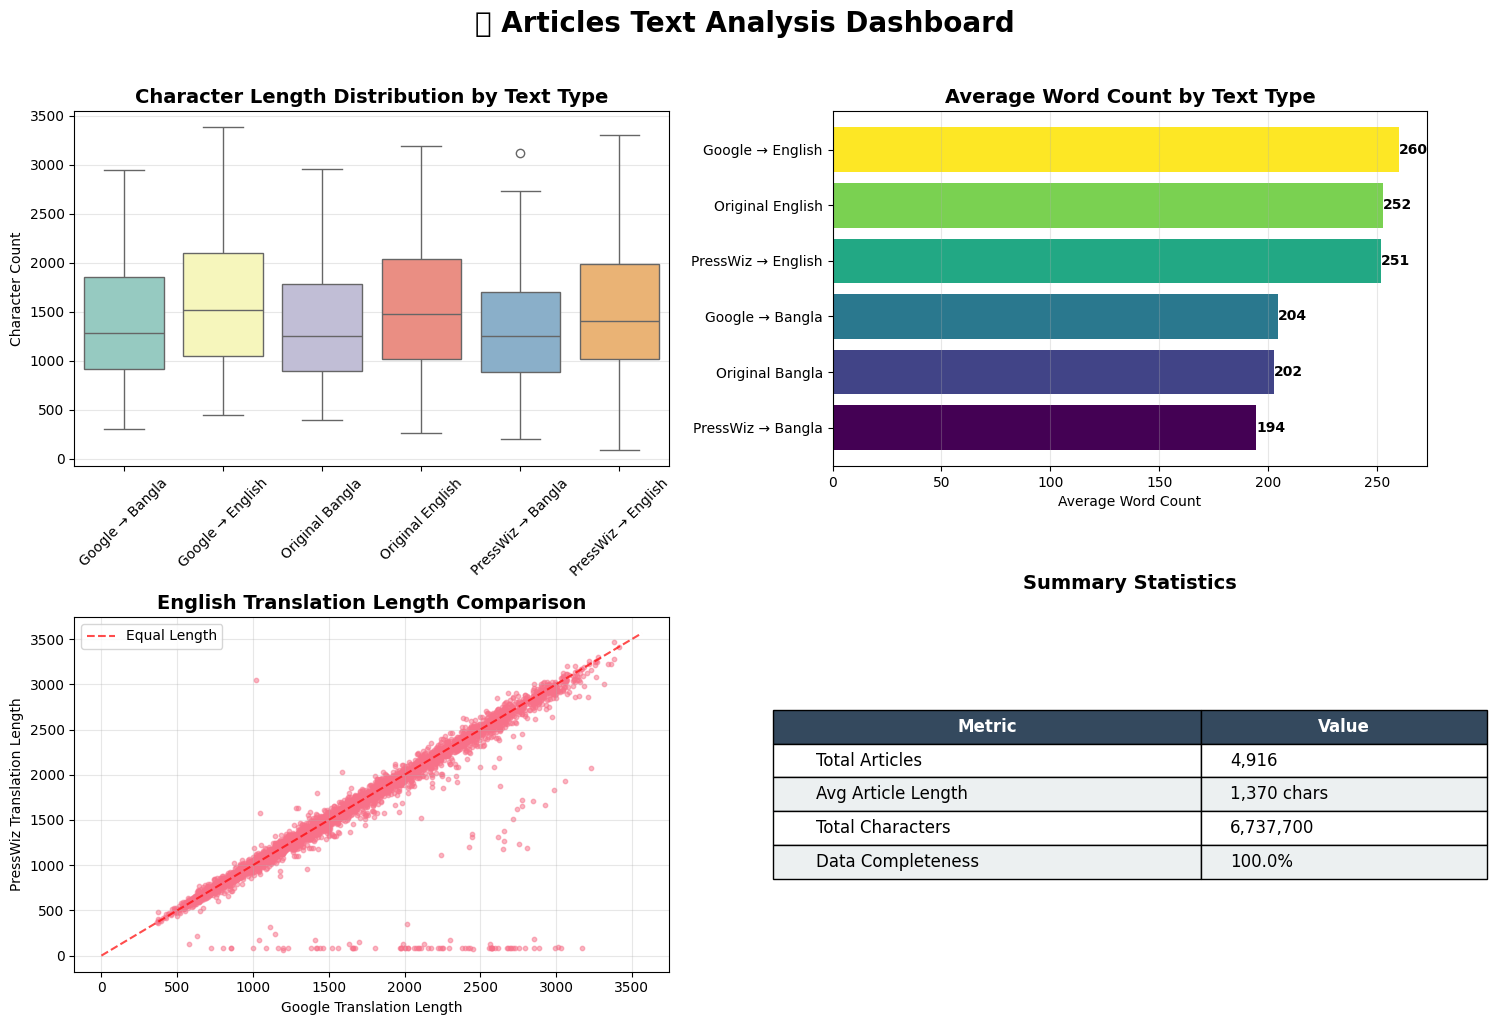


╔═══════════════════════════════════════════════════════════════╗
║                      💡 KEY INSIGHTS                           ║
╚═══════════════════════════════════════════════════════════════╝

📌 Average original Bangla article: 1,371 characters
📌 Average PressWiz English translation: 1,531 characters
📌 Translation expansion ratio: 1.12x
📌 PressWiz vs Google length difference: -2.5%


In [115]:
# Load and clean the data
input_path = '/home/server02/mahmud/mt/outputs/articles_final.csv'
articles = pd.read_csv(input_path)
articles = articles.dropna()

# ═══════════════════════════════════════════════════════════════════
#                   📰 SOME ARTICLES OVERVIEW
# ═══════════════════════════════════════════════════════════════════

# Define text columns
text_columns = {
    'textbn': 'Original Bangla',
    'texten': 'Original English', 
    'textbn_predicted': 'PressWiz → Bangla',
    'texten_predicted': 'PressWiz → English',
    'texten_gt': 'Google → English',
    'textbn_gt': 'Google → Bangla'
}

# Dataset dimensions
num_rows, num_cols = articles.shape
print("╔═══════════════════════════════════════════════════════════════╗")
print("║                  📰 ARTICLES Translation Overview              ║")
print("╚═══════════════════════════════════════════════════════════════╝")
print(f"\n📦 Total Articles: {num_rows:,}")
print(f"📊 Total Fields: {num_cols}")
print(f"🔤 Text Fields Analyzed: {len(text_columns)}")

# ═══════════════════════════════════════════════════════════════════
#                    📏 TEXT LENGTH STATISTICS
# ═══════════════════════════════════════════════════════════════════

# Calculate length statistics
length_data = {}
for col, name in text_columns.items():
    if col in articles.columns:
        lengths = articles[col].astype(str).str.len()
        length_data[name] = {
            'Mean': lengths.mean(),
            'Median': lengths.median(),
            'Std Dev': lengths.std(),
            'Min': lengths.min(),
            'Max': lengths.max(),
            'Q1 (25%)': lengths.quantile(0.25),
            'Q3 (75%)': lengths.quantile(0.75)
        }

# Create DataFrame for better visualization
length_df = pd.DataFrame(length_data).T

print("\n╔═══════════════════════════════════════════════════════════════╗")
print("║              📏 CHARACTER LENGTH STATISTICS                    ║")
print("╚═══════════════════════════════════════════════════════════════╝")

styled_length = (length_df.round(0)
                .style
                .background_gradient(cmap='RdYlBu_r', axis=0)
                .format("{:,.0f}")
                .set_properties(**{'text-align': 'right'})
                .set_table_styles([
                    {'selector': 'th', 'props': [('background-color', '#34495e'), 
                                                 ('color', 'white'),
                                                 ('font-weight', 'bold'),
                                                 ('padding', '10px')]},
                    {'selector': 'td', 'props': [('padding', '8px')]},
                    {'selector': 'tr:hover', 'props': [('background-color', '#f0f0f0')]}
                ]))
display(styled_length)

# ═══════════════════════════════════════════════════════════════════
#                    📊 WORD COUNT STATISTICS
# ═══════════════════════════════════════════════════════════════════

word_data = {}
for col, name in text_columns.items():
    if col in articles.columns:
        # Split by whitespace for word count (works for both Bangla and English)
        word_counts = articles[col].astype(str).str.split().str.len()
        word_data[name] = {
            'Mean Words': word_counts.mean(),
            'Median Words': word_counts.median(),
            'Min Words': word_counts.min(),
            'Max Words': word_counts.max(),
            'Total Words': word_counts.sum()
        }

word_df = pd.DataFrame(word_data).T

print("\n╔═══════════════════════════════════════════════════════════════╗")
print("║                  📊 WORD COUNT STATISTICS                      ║")
print("╚═══════════════════════════════════════════════════════════════╝")

styled_words = (word_df.round(0)
               .style
               .background_gradient(cmap='Greens', subset=['Mean Words', 'Median Words'])
               .format("{:,.0f}")
               .set_properties(**{'text-align': 'right'})
               .set_table_styles([
                   {'selector': 'th', 'props': [('background-color', '#27ae60'), 
                                                ('color', 'white'),
                                                ('font-weight', 'bold')]},
                   {'selector': 'td', 'props': [('padding', '8px')]}
               ]))
display(styled_words)

# ═══════════════════════════════════════════════════════════════════
#                 🔄 TRANSLATION COMPARISON ANALYSIS
# ═══════════════════════════════════════════════════════════════════

print("\n╔═══════════════════════════════════════════════════════════════╗")
print("║              🔄 TRANSLATION COMPARISON METRICS                 ║")
print("╚═══════════════════════════════════════════════════════════════╝")

# Compare PressWiz vs Google translations
comparison_data = []

# English translations comparison
if all(col in articles.columns for col in ['texten_predicted', 'texten_gt']):
    presswiz_en_len = articles['texten_predicted'].astype(str).str.len()
    google_en_len = articles['texten_gt'].astype(str).str.len()
    
    comparison_data.append({
        'Translation Direction': 'To English',
        'Avg Length Diff (PressWiz - Google)': (presswiz_en_len - google_en_len).mean(),
        'Median Length Diff': (presswiz_en_len - google_en_len).median(),
        '% Longer (PressWiz)': ((presswiz_en_len > google_en_len).sum() / len(articles) * 100)
    })

# Bangla translations comparison
if all(col in articles.columns for col in ['textbn_predicted', 'textbn_gt']):
    presswiz_bn_len = articles['textbn_predicted'].astype(str).str.len()
    google_bn_len = articles['textbn_gt'].astype(str).str.len()
    
    comparison_data.append({
        'Translation Direction': 'To Bangla',
        'Avg Length Diff (PressWiz - Google)': (presswiz_bn_len - google_bn_len).mean(),
        'Median Length Diff': (presswiz_bn_len - google_bn_len).median(),
        '% Longer (PressWiz)': ((presswiz_bn_len > google_bn_len).sum() / len(articles) * 100)
    })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    styled_comparison = (comparison_df.style
                        .format({'Avg Length Diff (PressWiz - Google)': '{:,.0f}',
                                'Median Length Diff': '{:,.0f}',
                                '% Longer (PressWiz)': '{:.1f}%'})
                        .background_gradient(cmap='coolwarm', subset=['Avg Length Diff (PressWiz - Google)'])
                        .set_properties(**{'text-align': 'center'}))
    display(styled_comparison)

# ═══════════════════════════════════════════════════════════════════
#                    📈 VISUAL ANALYSIS
# ═══════════════════════════════════════════════════════════════════

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('📰 Articles Text Analysis Dashboard', fontsize=20, fontweight='bold', y=1.02)

# 1. Length distribution boxplot
ax1 = axes[0, 0]
length_data_for_plot = []
for col, name in text_columns.items():
    if col in articles.columns:
        lengths = articles[col].astype(str).str.len()
        length_data_for_plot.extend([(name, l) for l in lengths])

plot_df = pd.DataFrame(length_data_for_plot, columns=['Type', 'Length'])
plot_df_sample = plot_df.groupby('Type').sample(min(1000, len(articles)), replace=True)

sns.boxplot(data=plot_df_sample, x='Type', y='Length', ax=ax1, palette='Set3')
ax1.set_title('Character Length Distribution by Text Type', fontsize=14, fontweight='bold')
ax1.set_xlabel('')
ax1.set_ylabel('Character Count')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# 2. Average word counts bar chart
ax2 = axes[0, 1]
avg_words = word_df['Mean Words'].sort_values(ascending=True)
bars = ax2.barh(avg_words.index, avg_words.values, color=plt.cm.viridis(np.linspace(0, 1, len(avg_words))))
ax2.set_title('Average Word Count by Text Type', fontsize=14, fontweight='bold')
ax2.set_xlabel('Average Word Count')
ax2.grid(axis='x', alpha=0.3)

# Add value labels on bars
for bar in bars:
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, 
             f'{int(width):,}', ha='left', va='center', fontweight='bold')

# 3. Translation length comparison
ax3 = axes[1, 0]
if 'texten_predicted' in articles.columns and 'texten_gt' in articles.columns:
    sample_size = min(5000, len(articles))
    sample_indices = np.random.choice(articles.index, sample_size, replace=False)
    
    ax3.scatter(articles.loc[sample_indices, 'texten_gt'].astype(str).str.len(),
                articles.loc[sample_indices, 'texten_predicted'].astype(str).str.len(),
                alpha=0.5, s=10)
    ax3.plot([0, ax3.get_xlim()[1]], [0, ax3.get_xlim()[1]], 'r--', alpha=0.7, label='Equal Length')
    ax3.set_xlabel('Google Translation Length')
    ax3.set_ylabel('PressWiz Translation Length')
    ax3.set_title('English Translation Length Comparison', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Summary statistics table
ax4 = axes[1, 1]
ax4.axis('tight')
ax4.axis('off')

summary_stats = {
    'Total Articles': f'{num_rows:,}',
    'Avg Article Length': f'{int(articles[list(text_columns.keys())[0]].astype(str).str.len().mean()):,} chars',
    'Total Characters': f'{int(articles[list(text_columns.keys())[0]].astype(str).str.len().sum()):,}',
    'Data Completeness': f'{((len(articles) / num_rows) * 100):.1f}%'
}

table_data = [[k, v] for k, v in summary_stats.items()]
table = ax4.table(cellText=table_data, 
                  colLabels=['Metric', 'Value'],
                  cellLoc='left',
                  loc='center',
                  colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)

# Style the table
for i in range(len(table_data) + 1):
    for j in range(2):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#34495e')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#ecf0f1' if i % 2 == 0 else 'white')

ax4.set_title('Summary Statistics', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# ═══════════════════════════════════════════════════════════════════
#                    💡 KEY INSIGHTS
# ═══════════════════════════════════════════════════════════════════

print("\n╔═══════════════════════════════════════════════════════════════╗")
print("║                      💡 KEY INSIGHTS                           ║")
print("╚═══════════════════════════════════════════════════════════════╝")

# Calculate some key insights
if all(col in articles.columns for col in text_columns.keys()):
    avg_original_len = articles['textbn'].astype(str).str.len().mean()
    avg_translated_len = articles['texten_predicted'].astype(str).str.len().mean()
    
    print(f"\n📌 Average original Bangla article: {avg_original_len:,.0f} characters")
    print(f"📌 Average PressWiz English translation: {avg_translated_len:,.0f} characters")
    print(f"📌 Translation expansion ratio: {(avg_translated_len/avg_original_len):.2f}x")
    
    if 'texten_gt' in articles.columns:
        avg_google_len = articles['texten_gt'].astype(str).str.len().mean()
        print(f"📌 PressWiz vs Google length difference: {((avg_translated_len - avg_google_len)/avg_google_len * 100):.1f}%")

In [116]:
# ═══════════════════════════════════════════════════════════════════
#                   📰 Articles with SUMMARIES DATASET OVERVIEW
# ═══════════════════════════════════════════════════════════════════

# Set modern styling
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

def safe_column_check(df, columns):
    """Safely check if columns exist in dataframe"""
    if isinstance(columns, str):
        columns = [columns]
    return all(col in df.columns for col in columns)

def safe_numeric_operation(series, operation='mean'):
    """Safely perform numeric operations on series"""
    try:
        numeric_series = pd.to_numeric(series, errors='coerce')
        if operation == 'mean':
            return numeric_series.mean()
        elif operation == 'median':
            return numeric_series.median()
        elif operation == 'std':
            return numeric_series.std()
        elif operation == 'min':
            return numeric_series.min()
        elif operation == 'max':
            return numeric_series.max()
        else:
            return numeric_series.quantile(operation)
    except:
        return 0

# Define text columns with validation
text_columns = {
    'content': 'Full Article (Bangla)',
    'content_en': 'Full Article (English)',
    'summary': 'Summary (Bangla)',
    'summary_en': 'Summary (English)',
    'summary_en_gt': 'Summary Bangla→English (Google)',
    'summary_gt': 'Summary English→Bangla (Google)'
}

# Validate dataset exists and get basic info
try:
    num_rows, num_cols = summaries.shape
    unique_sources = summaries['source_name'].nunique() if safe_column_check(summaries, 'source_name') else 0
    available_text_cols = {k: v for k, v in text_columns.items() if k in summaries.columns}
    
    print("╔═══════════════════════════════════════════════════════════════╗")
    print("║                 📰 Articles with SUMMARIES OVERVIEW           ║")
    print("╚═══════════════════════════════════════════════════════════════╝")
    print(f"\n📦 Total Articles: {num_rows:,}")
    print(f"📊 Total Fields: {num_cols}")
    print(f"🗞️ Unique News Sources: {unique_sources}")
    print(f"🔤 Available Text Fields: {len(available_text_cols)}/{len(text_columns)}")
    
    # Show missing columns if any
    if len(available_text_cols) != len(text_columns):
        missing_cols = set(text_columns.keys()) - set(available_text_cols.keys())
        print(f"⚠️  Missing columns: {', '.join(missing_cols)}")
        
except NameError:
    print("❌ Error: 'summaries' dataset not found. Please load the dataset first.")
    print("   Example: summaries = pd.read_csv('your_dataset.csv')")
    raise

# ═══════════════════════════════════════════════════════════════════
#                    📏 TEXT LENGTH STATISTICS
# ═══════════════════════════════════════════════════════════════════

if available_text_cols:
    print("\n╔═══════════════════════════════════════════════════════════════╗")
    print("║              📏 CHARACTER LENGTH STATISTICS                    ║")
    print("╚═══════════════════════════════════════════════════════════════╝")

    # Calculate length statistics with error handling
    length_data = {}
    for col, name in available_text_cols.items():
        try:
            # Handle NaN values and convert to string
            clean_series = summaries[col].fillna('').astype(str)
            lengths = clean_series.str.len()
            
            length_data[name] = {
                'Mean': safe_numeric_operation(lengths, 'mean'),
                'Median': safe_numeric_operation(lengths, 'median'),
                'Std Dev': safe_numeric_operation(lengths, 'std'),
                'Min': safe_numeric_operation(lengths, 'min'),
                'Max': safe_numeric_operation(lengths, 'max'),
                'Q1 (25%)': safe_numeric_operation(lengths, 0.25),
                'Q3 (75%)': safe_numeric_operation(lengths, 0.75)
            }
        except Exception as e:
            print(f"⚠️ Error processing column {col}: {e}")
            continue

    # Create DataFrame for better visualization
    if length_data:
        length_df = pd.DataFrame(length_data).T

        styled_length = (length_df.round(0)
                        .style
                        .background_gradient(cmap='RdYlBu_r', axis=0)
                        .format("{:,.0f}")
                        .set_properties(**{
                            'text-align': 'center',
                            'font-weight': 'bold',
                            'font-size': '11px'
                        })
                        .set_table_styles([
                            {'selector': 'th', 
                             'props': [('background-color', '#2c3e50'), 
                                      ('color', 'white'),
                                      ('font-weight', 'bold'),
                                      ('padding', '12px'),
                                      ('text-align', 'center'),
                                      ('border', '1px solid #34495e')]},
                            {'selector': 'td', 
                             'props': [('padding', '10px'),
                                      ('border', '1px solid #ecf0f1')]},
                            {'selector': 'tr:hover', 
                             'props': [('background-color', '#f8f9fa')]},
                            {'selector': 'table', 
                             'props': [('border-collapse', 'collapse'),
                                      ('margin', '15px auto'),
                                      ('box-shadow', '0 2px 4px rgba(0,0,0,0.1)')]}
                        ]))
        display(styled_length)

    # ═══════════════════════════════════════════════════════════════════
    #                    📊 WORD COUNT STATISTICS
    # ═══════════════════════════════════════════════════════════════════

    print("\n╔═══════════════════════════════════════════════════════════════╗")
    print("║                  📊 WORD COUNT STATISTICS                      ║")
    print("╚═══════════════════════════════════════════════════════════════╝")

    word_data = {}
    for col, name in available_text_cols.items():
        try:
            clean_series = summaries[col].fillna('').astype(str)
            word_counts = clean_series.str.split().str.len().fillna(0)
            
            word_data[name] = {
                'Mean Words': safe_numeric_operation(word_counts, 'mean'),
                'Median Words': safe_numeric_operation(word_counts, 'median'),
                'Min Words': safe_numeric_operation(word_counts, 'min'),
                'Max Words': safe_numeric_operation(word_counts, 'max'),
                'Total Words': word_counts.sum()
            }
        except Exception as e:
            print(f"⚠️ Error processing word counts for {col}: {e}")
            continue

    if word_data:
        word_df = pd.DataFrame(word_data).T

        styled_words = (word_df.round(0)
                       .style
                       .background_gradient(cmap='Greens', subset=['Mean Words', 'Median Words'])
                       .background_gradient(cmap='Blues', subset=['Total Words'])
                       .format("{:,.0f}")
                       .set_properties(**{
                           'text-align': 'center',
                           'font-weight': 'bold',
                           'font-size': '11px'
                       })
                       .set_table_styles([
                           {'selector': 'th', 
                            'props': [('background-color', '#27ae60'), 
                                     ('color', 'white'),
                                     ('font-weight', 'bold'),
                                     ('padding', '12px'),
                                     ('text-align', 'center'),
                                     ('border', '1px solid #229954')]},
                           {'selector': 'td', 
                            'props': [('padding', '10px'),
                                     ('border', '1px solid #d5f4e6')]},
                           {'selector': 'table', 
                            'props': [('border-collapse', 'collapse'),
                                     ('margin', '15px auto'),
                                     ('box-shadow', '0 2px 4px rgba(0,0,0,0.1)')]}
                       ]))
        display(styled_words)

# ═══════════════════════════════════════════════════════════════════
#                 📈 COMPRESSION RATIO ANALYSIS
# ═══════════════════════════════════════════════════════════════════

print("\n╔═══════════════════════════════════════════════════════════════╗")
print("║              📈 SUMMARIZATION COMPRESSION METRICS              ║")
print("╚═══════════════════════════════════════════════════════════════╝")

def calculate_compression_safely(content_col, summary_col, language):
    """Safely calculate compression metrics"""
    try:
        if not safe_column_check(summaries, [content_col, summary_col]):
            return None
            
        # Clean data and handle NaN values
        content_clean = summaries[content_col].fillna('').astype(str)
        summary_clean = summaries[summary_col].fillna('').astype(str)
        
        content_len = content_clean.str.len()
        summary_len = summary_clean.str.len()
        
        # Avoid division by zero
        valid_mask = (content_len > 0) & (summary_len > 0)
        if valid_mask.sum() == 0:
            return None
            
        compression_ratio = summary_len[valid_mask] / content_len[valid_mask]
        
        return {
            'Language': language,
            'Valid Samples': valid_mask.sum(),
            'Avg Compression Ratio': compression_ratio.mean(),
            'Median Compression Ratio': compression_ratio.median(),
            'Std Compression': compression_ratio.std(),
            'Avg Summary Length': summary_len[valid_mask].mean(),
            'Avg Content Length': content_len[valid_mask].mean(),
            'Length Reduction %': ((1 - compression_ratio.mean()) * 100)
        }
    except Exception as e:
        print(f"⚠️ Error calculating compression for {language}: {e}")
        return None

compression_data = []

# Analyze compression for both languages
language_pairs = [
    ('content', 'summary', 'Bangla'),
    ('content_en', 'summary_en', 'English')
]

for content_col, summary_col, lang in language_pairs:
    result = calculate_compression_safely(content_col, summary_col, lang)
    if result:
        compression_data.append(result)

if compression_data:
    compression_df = pd.DataFrame(compression_data)
    
    styled_compression = (compression_df.style
                         .format({
                             'Valid Samples': '{:,}',
                             'Avg Compression Ratio': '{:.3f}',
                             'Median Compression Ratio': '{:.3f}',
                             'Std Compression': '{:.3f}',
                             'Avg Summary Length': '{:,.0f}',
                             'Avg Content Length': '{:,.0f}',
                             'Length Reduction %': '{:.1f}%'
                         })
                         .background_gradient(cmap='RdYlGn', subset=['Length Reduction %'])
                         .background_gradient(cmap='viridis', subset=['Avg Compression Ratio'])
                         .set_properties(**{
                             'text-align': 'center',
                             'font-weight': 'bold',
                             'font-size': '11px'
                         })
                         .set_table_styles([
                             {'selector': 'th', 
                              'props': [('background-color', '#e74c3c'),
                                       ('color', 'white'),
                                       ('font-weight', 'bold'),
                                       ('padding', '12px'),
                                       ('border', '1px solid #c0392b')]},
                             {'selector': 'td', 
                              'props': [('padding', '10px'),
                                       ('border', '1px solid #fadbd8')]},
                             {'selector': 'table', 
                              'props': [('border-collapse', 'collapse'),
                                       ('margin', '15px auto'),
                                       ('box-shadow', '0 2px 4px rgba(0,0,0,0.1)')]}
                         ]))
    display(styled_compression)
else:
    print("⚠️ No valid compression data found. Check if content and summary columns exist and contain data.")



╔═══════════════════════════════════════════════════════════════╗
║                 📰 Articles with SUMMARIES OVERVIEW           ║
╚═══════════════════════════════════════════════════════════════╝

📦 Total Articles: 1,503
📊 Total Fields: 8
🗞️ Unique News Sources: 3
🔤 Available Text Fields: 6/6

╔═══════════════════════════════════════════════════════════════╗
║              📏 CHARACTER LENGTH STATISTICS                    ║
╚═══════════════════════════════════════════════════════════════╝


,Mean,Median,Std Dev,Min,Max,Q1 (25%),Q3 (75%)
Full Article (Bangla),"1,247","1,166",591,106,"3,777",804,"1,588"
Full Article (English),"1,421","1,341",676,71,"3,417",920,"1,834"
Summary (Bangla),561,540,232,55,"5,017",424,677
Summary (English),567,554,208,68,"2,658",428,699
Summary Bangla→English (Google),616,597,262,68,"5,954",464,744
Summary English→Bangla (Google),564,551,208,61,"2,483",421,693



╔═══════════════════════════════════════════════════════════════╗
║                  📊 WORD COUNT STATISTICS                      ║
╚═══════════════════════════════════════════════════════════════╝


,Mean Words,Median Words,Min Words,Max Words,Total Words
Full Article (Bangla),186,172,16,"1,017","279,977"
Full Article (English),232,218,12,933,"348,222"
Summary (Bangla),84,81,9,682,"125,938"
Summary (English),87,85,12,498,"130,848"
Summary Bangla→English (Google),100,97,10,971,"149,914"
Summary English→Bangla (Google),83,81,10,412,"124,828"



╔═══════════════════════════════════════════════════════════════╗
║              📈 SUMMARIZATION COMPRESSION METRICS              ║
╚═══════════════════════════════════════════════════════════════╝


,Language,Valid Samples,Avg Compression Ratio,Median Compression Ratio,Std Compression,Avg Summary Length,Avg Content Length,Length Reduction %
0,Bangla,"1,503",0.514,0.471,0.528,561,"1,247",48.6%
1,English,"1,503",0.442,0.422,0.137,567,"1,421",55.8%


# BLUE Score

In [117]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    'BLTokenizer',
    local_files_only=True,
    use_fast=True,
    add_prefix_space=False
)

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [118]:
# Define tokenization function using your tokenizer
def tokenize(text):
    if not isinstance(text, str):
        return []
    return tokenizer.tokenize(text.strip())

### PressWiz BLEU Score

In [119]:
print("BLEU Score(PressWiz)")

# Initialize
smoothie = SmoothingFunction().method4
bleu_bn2en_scores = []
bleu_en2bn_scores = []


# Drop missing or invalid rows
required_cols = ['textbn', 'texten', 'textbn_predicted', 'texten_predicted']

df_clean = articles.copy()

# Loop with progress bar
for _, row in tqdm(df_clean.iterrows(), total=len(df_clean), desc="Calculating BLEU"):

    # BN → EN
    ref_en = tokenize(row['texten'])
    pred_en = tokenize(row['texten_predicted'])

    bleu_bn2en = sentence_bleu([ref_en], pred_en, smoothing_function=smoothie) if ref_en and pred_en else 0.0
    bleu_bn2en_scores.append(bleu_bn2en)

    # EN → BN
    ref_bn = tokenize(row['textbn'])
    pred_bn = tokenize(row['textbn_predicted'])

    bleu_en2bn = sentence_bleu([ref_bn], pred_bn, smoothing_function=smoothie) if ref_bn and pred_bn else 0.0
    bleu_en2bn_scores.append(bleu_en2bn)

# Averages
avg_bleu_bn2en = np.mean(bleu_bn2en_scores)
avg_bleu_en2bn = np.mean(bleu_en2bn_scores)

# Display
print(f"\nAverage BLEU Score (BN → EN): {avg_bleu_bn2en:.4f}")
print(f"Average BLEU Score (EN → BN): {avg_bleu_en2bn:.4f}")

BLEU Score(PressWiz)


Calculating BLEU:   0%|          | 0/4916 [00:00<?, ?it/s]


Average BLEU Score (BN → EN): 0.5485
Average BLEU Score (EN → BN): 0.4395


### Google Translator BLEU Score

In [120]:
print("BLEU Score(Google Translator)")
# Initialize
smoothie = SmoothingFunction().method4
bleu_bn2en_scores = []
bleu_en2bn_scores = []

# Drop missing or invalid rows
required_cols = ['textbn', 'texten', 'textbn_gt', 'texten_gt']
df_clean = articles.copy()

# Loop with progress bar
for _, row in tqdm(df_clean.iterrows(), total=len(df_clean), desc="Calculating BLEU"):

    # BN → EN
    ref_en = tokenize(row['texten'])
    pred_en = tokenize(row['texten_gt'])

    bleu_bn2en = sentence_bleu([ref_en], pred_en, smoothing_function=smoothie) if ref_en and pred_en else 0.0
    bleu_bn2en_scores.append(bleu_bn2en)

    # EN → BN
    ref_bn = tokenize(row['textbn'])
    pred_bn = tokenize(row['textbn_gt'])

    bleu_en2bn = sentence_bleu([ref_bn], pred_bn, smoothing_function=smoothie) if ref_bn and pred_bn else 0.0
    bleu_en2bn_scores.append(bleu_en2bn)

# Averages
avg_bleu_bn2en = np.mean(bleu_bn2en_scores)
avg_bleu_en2bn = np.mean(bleu_en2bn_scores)

# Display
print(f"\nAverage BLEU Score (BN → EN): {avg_bleu_bn2en:.4f}")
print(f"Average BLEU Score (EN → BN): {avg_bleu_en2bn:.4f}")


BLEU Score(Google Translator)


Calculating BLEU:   0%|          | 0/4916 [00:00<?, ?it/s]


Average BLEU Score (BN → EN): 0.5398
Average BLEU Score (EN → BN): 0.2962


# ScareBLEU

In [121]:
# Tokenize using your tokenizer and join back into space-separated string
def tokenize_text(text):
    return " ".join(tokenizer.tokenize(str(text).strip()))

### PressWiz SacreBLEU

In [122]:
print("SacreBLEU Score(PressWiz)")

df_clean = articles.copy()

# Apply tokenizer
df_clean['texten_tok'] = df_clean['texten'].apply(tokenize_text)
df_clean['texten_pred_tok'] = df_clean['texten_predicted'].apply(tokenize_text)

df_clean['textbn_tok'] = df_clean['textbn'].apply(tokenize_text)
df_clean['textbn_pred_tok'] = df_clean['textbn_predicted'].apply(tokenize_text)

# BN → EN
references_en = [[ref for ref in df_clean['texten_tok']]]
predictions_en = [pred for pred in df_clean['texten_pred_tok']]
bleu_bn2en = sacrebleu.corpus_bleu(predictions_en, references_en)
print(f"SacreBLEU (BN → EN): {bleu_bn2en.score:.2f}")

# EN → BN
references_bn = [[ref for ref in df_clean['textbn_tok']]]
predictions_bn = [pred for pred in df_clean['textbn_pred_tok']]
bleu_en2bn = sacrebleu.corpus_bleu(predictions_bn, references_bn)
print(f"SacreBLEU (EN → BN): {bleu_en2bn.score:.2f}")

SacreBLEU Score(PressWiz)


That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


SacreBLEU (BN → EN): 56.36
SacreBLEU (EN → BN): 43.75


### Google Translator SacreBLEU

In [123]:
print("SacreBLEU Score(Google Translator)")

df_clean = articles.copy()

# Apply tokenizer
df_clean['texten_tok'] = df_clean['texten'].apply(tokenize_text)
df_clean['texten_pred_tok'] = df_clean['texten_gt'].apply(tokenize_text)

df_clean['textbn_tok'] = df_clean['textbn'].apply(tokenize_text)
df_clean['textbn_pred_tok'] = df_clean['textbn_gt'].apply(tokenize_text)

# BN → EN
references_en = [[ref for ref in df_clean['texten_tok']]]
predictions_en = [pred for pred in df_clean['texten_pred_tok']]
bleu_bn2en = sacrebleu.corpus_bleu(predictions_en, references_en)
print(f"SacreBLEU (BN → EN): {bleu_bn2en.score:.2f}")

# EN → BN
references_bn = [[ref for ref in df_clean['textbn_tok']]]
predictions_bn = [pred for pred in df_clean['textbn_pred_tok']]
bleu_en2bn = sacrebleu.corpus_bleu(predictions_bn, references_bn)
print(f"SacreBLEU (EN → BN): {bleu_en2bn.score:.2f}")

SacreBLEU Score(Google Translator)


That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.


SacreBLEU (BN → EN): 55.52
SacreBLEU (EN → BN): 29.92


# ROUGE Score

### PressWiz ROUGE Scores

In [124]:
print('PressWiz ROUGE Scores')
rouge = Rouge()
rouge_1_scores = []
rouge_l_scores = []
df = summaries.copy()

for _, row in tqdm(df.iterrows(), total=len(df), desc="Calculating ROUGE"):
    try:
        article = normalize(str(row['content']))
        summary = normalize(str(row['summary']))

        # Compute ROUGE
        scores = rouge.get_scores(summary, article)[0]  # (hypothesis, reference)
        rouge_1_scores.append(scores['rouge-1']['f'])
        rouge_l_scores.append(scores['rouge-l']['f'])

    except Exception as e:
        rouge_1_scores.append(0)
        rouge_l_scores.append(0)

# Average scores
print(f"Average ROUGE-1 F1: {np.mean(rouge_1_scores):.4f}")
print(f"Average ROUGE-L F1: {np.mean(rouge_l_scores):.4f}")


PressWiz ROUGE Scores


Calculating ROUGE:   0%|          | 0/1503 [00:00<?, ?it/s]

Average ROUGE-1 F1: 0.4498
Average ROUGE-L F1: 0.3492


### (Google Translator + QWEN) ROUGE Scores

In [125]:
print('Google Translator ROUGE Scores')
rouge = Rouge()
rouge_1_scores = []
rouge_l_scores = []
df = summaries.copy()

for _, row in tqdm(df.iterrows(), total=len(df), desc="Calculating ROUGE"):
    try:
        article = normalize(str(row['content']))
        summary = normalize(str(row['summary_gt']))

        # Compute ROUGE
        scores = rouge.get_scores(summary, article)[0]  # (hypothesis, reference)
        rouge_1_scores.append(scores['rouge-1']['f'])
        rouge_l_scores.append(scores['rouge-l']['f'])

    except Exception as e:
        rouge_1_scores.append(0)
        rouge_l_scores.append(0)

# Average scores
print(f"Average ROUGE-1 F1: {np.mean(rouge_1_scores):.4f}")
print(f"Average ROUGE-L F1: {np.mean(rouge_l_scores):.4f}")

Google Translator ROUGE Scores


Calculating ROUGE:   0%|          | 0/1503 [00:00<?, ?it/s]

Average ROUGE-1 F1: 0.3835
Average ROUGE-L F1: 0.2906


# BERT F1

### BERTScore F1 (PressWiz)

🔍 PressWiz BERTScore F1
calculating scores...
computing bert embedding.


  0%|          | 0/47 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/24 [00:00<?, ?it/s]

done in 20.49 seconds, 73.34 sentences/sec
✅ Average BERTScore F1 (content ↔ summary) by PressWiz: 0.7807


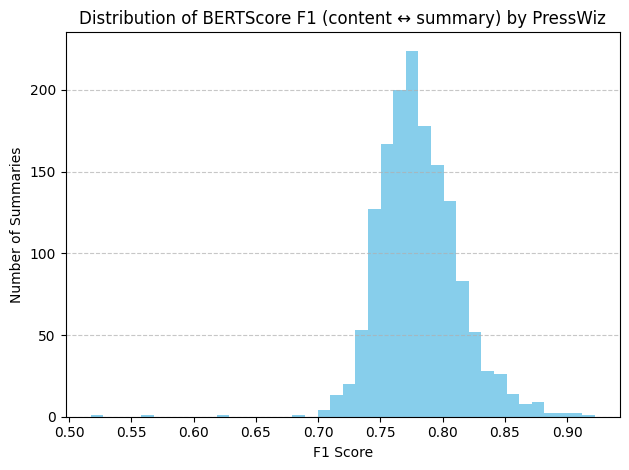

In [136]:
print('🔍 PressWiz BERTScore F1')

# Copy the summaries DataFrame
df = summaries.copy()

# Create lists
P_all = df['summary'].tolist()   # Predictions (summaries)
R_all = df['content'].tolist()   # References (source content)

# Use BERTScore to compute F1 scores (with tqdm progress bar)
_, _, F1 = score(P_all, R_all, lang='bn', verbose=True)

# Convert F1 tensor to list
all_f1 = F1.tolist()

# Calculate and print average F1
avg_f1 = sum(all_f1) / len(all_f1)
print(f"✅ Average BERTScore F1 (content ↔ summary) by PressWiz: {avg_f1:.4f}")

# Plot histogram of F1 scores
plt.hist(F1, bins=40, color='skyblue')
plt.title("Distribution of BERTScore F1 (content ↔ summary) by PressWiz")
plt.xlabel("F1 Score")
plt.ylabel("Number of Summaries")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### BERTScore F1(Google Translator)

Google Translator BERTScore F1
calculating scores...
computing bert embedding.


  0%|          | 0/47 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/24 [00:00<?, ?it/s]

done in 20.66 seconds, 72.76 sentences/sec
✅ Average BERTScore F1 (content ↔ summary_gt) by Google Translator: 0.7694


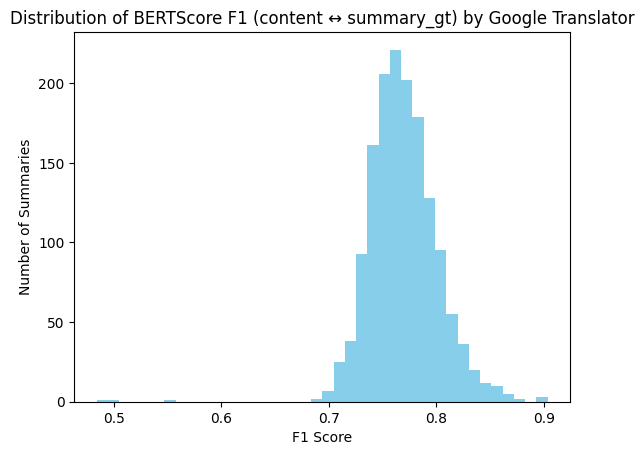

In [137]:
print('Google Translator BERTScore F1')

# Copy the summaries DataFrame
df = summaries.copy()

# Create lists
P_all = df['summary_gt'].tolist()   # Predictions (summaries)
R_all = df['content'].tolist()   # References (source content)

# Use BERTScore to compute F1 scores (with tqdm progress bar)
_, _, F1 = score(P_all, R_all, lang='bn', verbose=True)

# Convert F1 tensor to list
all_f1 = F1.tolist()

# Calculate and print average F1
avg_f1 = sum(all_f1) / len(all_f1)
print(f"✅ Average BERTScore F1 (content ↔ summary_gt) by Google Translator: {avg_f1:.4f}")

plt.hist(F1, bins=40, color='skyblue')
plt.title("Distribution of BERTScore F1 (content ↔ summary_gt) by Google Translator")
plt.xlabel("F1 Score")
plt.ylabel("Number of Summaries")
plt.show()